In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.io.wavfile
import scipy.signal
from scipy import signal
from scipy.signal import butter, iirnotch, lfilter, sosfilt, sosfreqz, filtfilt, sosfiltfilt
from scipy.fft import fft, fftfreq

In [2]:
plt.rcParams["figure.figsize"] = (20,10)

In [3]:
def butter_highpass(cutoff, sample_rate, order, data):
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    final_filtered_highpass = filtfilt(b, a, data)
    return final_filtered_highpass

In [4]:
def butter_lowpass(cutoff, sample_rate, order, data, slice=-1):
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_lowpass = lfilter(b,a,data)
    return filtered_lowpass

In [5]:
def moving_average_filter(x, w):
    m_a_filtered = np.convolve(x, np.ones(w), 'same') / w
    return m_a_filtered

In [6]:
def filter_data(data, sample_rate=100):
    m_a_filtered = moving_average_filter(data, 5)
    filtered_data_1 = butter_highpass(0.5, sample_rate, 2, m_a_filtered)
    final_filtered_data = butter_lowpass(49, sample_rate, 5, filtered_data_1)
    return final_filtered_data

In [7]:
def plot_signals_for_comparison(original_signal,filtered_signal):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    ax1.set_title('Raw ECG')
    ax1.plot(original_signal);
    ax1.grid()
    ax2.set_title('Filtered ECG [0.5Hz - 49Hz]')
    ax2.plot(filtered_signal);
    ax2.set_xlabel('Time [100 miliseconds]');
    ax2.grid()
    plt.tight_layout()
    plt.show()

In [9]:
ls ../

Op‡Æo inv lida - "".


In [10]:
!ls ../data

'ls' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.


In [8]:
df = pd.read_csv("ECG_Rhythm_Lead_I.csv")
df.shape

(21837, 1007)

In [9]:
df.head(2)

,Unnamed: 0,ecg_id,age,sex,height,weight,rhythm_diag,0,1,2,...,990,991,992,993,994,995,996,997,998,999
0,0,1,56.0,1,NaN,63.0,SR,-0.119,-0.116,-0.120,...,0.198,0.194,0.115,0.107,0.107,0.106,0.090,0.069,0.086,0.022
1,1,2,19.0,0,NaN,70.0,OTHER,0.004,-0.020,-0.053,...,-0.035,-0.045,0.004,0.044,0.507,0.554,0.316,0.121,-0.326,-0.348


In [10]:
del df["Unnamed: 0"]

In [11]:
df.rhythm_diag.value_counts()

SR       16782
OTHER     3541
AFIB      1514
Name: rhythm_diag, dtype: int64

In [12]:
df = df.loc[df.rhythm_diag != 'OTHER']
df.shape

(18296, 1006)

In [13]:
df.rhythm_diag.value_counts()

SR      16782
AFIB     1514
Name: rhythm_diag, dtype: int64

In [14]:
df.replace({'rhythm_diag': {'SR': 0, 'AFIB': 1}}, inplace=True)
df.rhythm_diag.value_counts()

0    16782
1     1514
Name: rhythm_diag, dtype: int64

In [15]:
from sklearn.utils import resample

In [16]:
df_minority = df[df['rhythm_diag']==1]
df_majority = df[df['rhythm_diag']==0]

In [17]:
maj_class = resample(df_majority,
                     replace=True,
                     n_samples=1514,
                     random_state=123)

In [18]:
maj_class.shape

(1514, 1006)

In [19]:
df=pd.concat([df_minority,maj_class])
df.shape

(3028, 1006)

In [20]:
df.rhythm_diag.value_counts()

0    1514
1    1514
Name: rhythm_diag, dtype: int64

In [21]:
df.head(2)

,ecg_id,age,sex,height,weight,rhythm_diag,0,1,2,3,...,990,991,992,993,994,995,996,997,998,999
16,17,56.0,0,NaN,NaN,1,-0.041,-0.025,0.041,0.036,...,-0.074,-0.054,-0.036,-0.027,0.02,0.028,0.055,0.063,0.058,0.079
151,152,70.0,1,NaN,NaN,1,-0.008,-0.029,-0.026,-0.006,...,0.067,0.055,0.037,0.038,0.06,0.084,0.113,0.097,0.076,0.058


In [22]:
df.tail(2)

,ecg_id,age,sex,height,weight,rhythm_diag,0,1,2,3,...,990,991,992,993,994,995,996,997,998,999
7970,7971,85.0,0,NaN,NaN,0,-0.566,-0.578,-0.612,-0.400,...,0.363,0.846,0.475,0.013,-0.074,-0.102,-0.109,-0.125,-0.138,-0.128
202,203,46.0,0,NaN,69.0,0,-0.085,-0.085,-0.089,-0.092,...,-0.073,-0.086,-0.077,-0.056,-0.064,-0.069,-0.118,-0.031,0.058,0.043


`First half of dataset has AFIB data [1] and second half SR [0]`

In [23]:
df[df.rhythm_diag == 0]['age'].mean()

57.76275679257787

In [24]:
df[df.rhythm_diag == 1]['age'].mean()

70.79839249832551

In [25]:
X = df.drop(['ecg_id', 'age', 'sex', 'height', 'weight', 'rhythm_diag'], axis=1).values
y = df.rhythm_diag.values
X.shape, y.shape

((3028, 1000), (3028,))

In [26]:
df[df.rhythm_diag == 0]['sex'].mean()

0.4960369881109643

In [27]:
df[df.rhythm_diag == 1]['sex'].mean()

0.4425363276089828

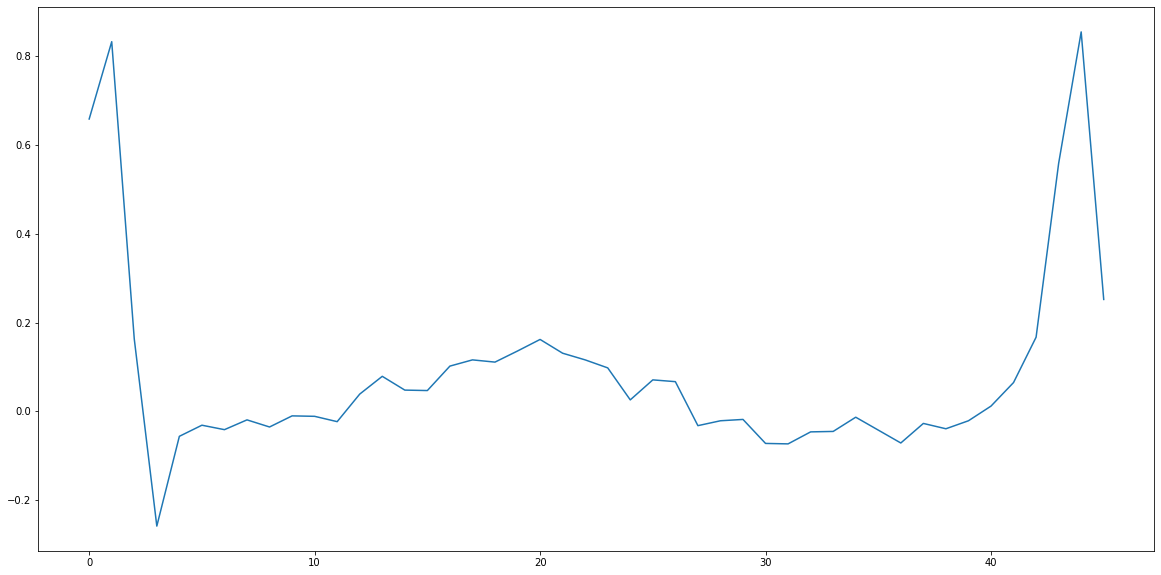

In [28]:
plt.plot(X[0, 35:(35+46)]);

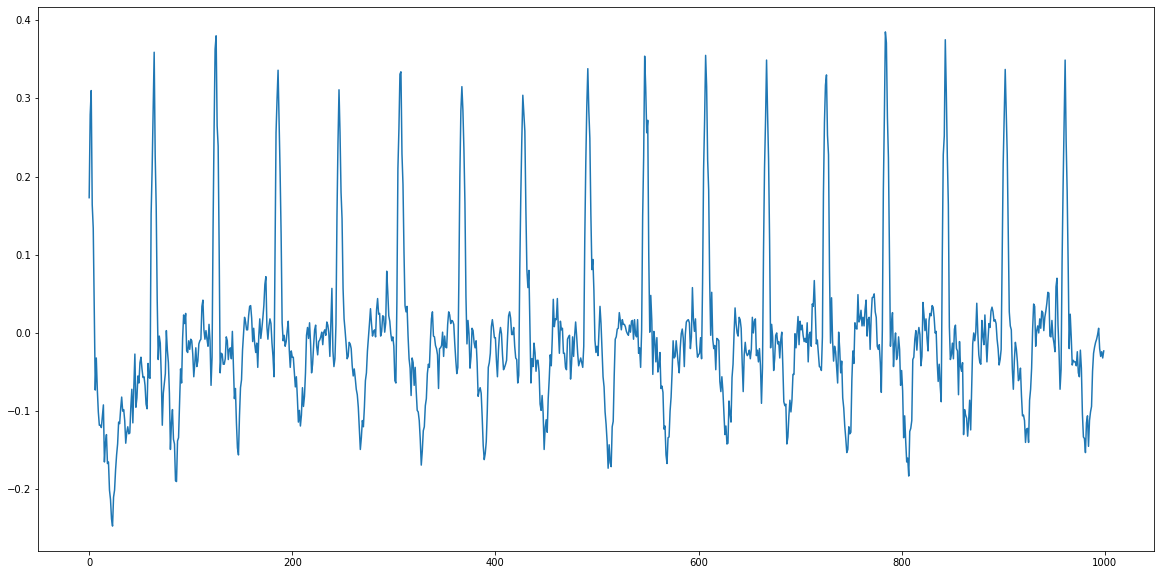

In [29]:
plt.plot(X[2080]);

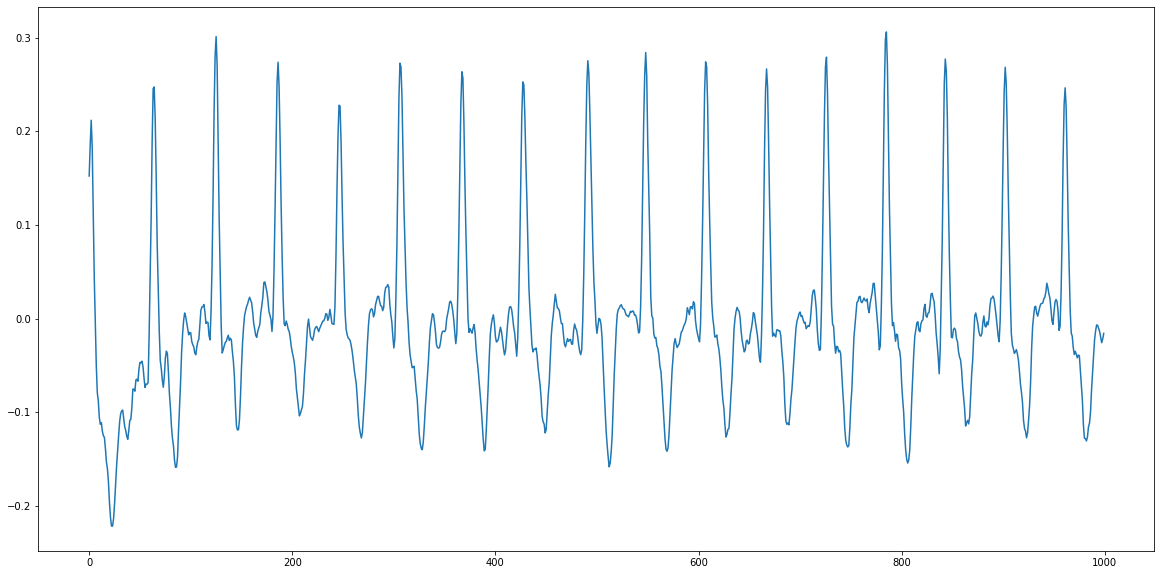

In [24]:
m_a_filtered = moving_average_filter(X[2080], 5)
plt.plot(m_a_filtered);

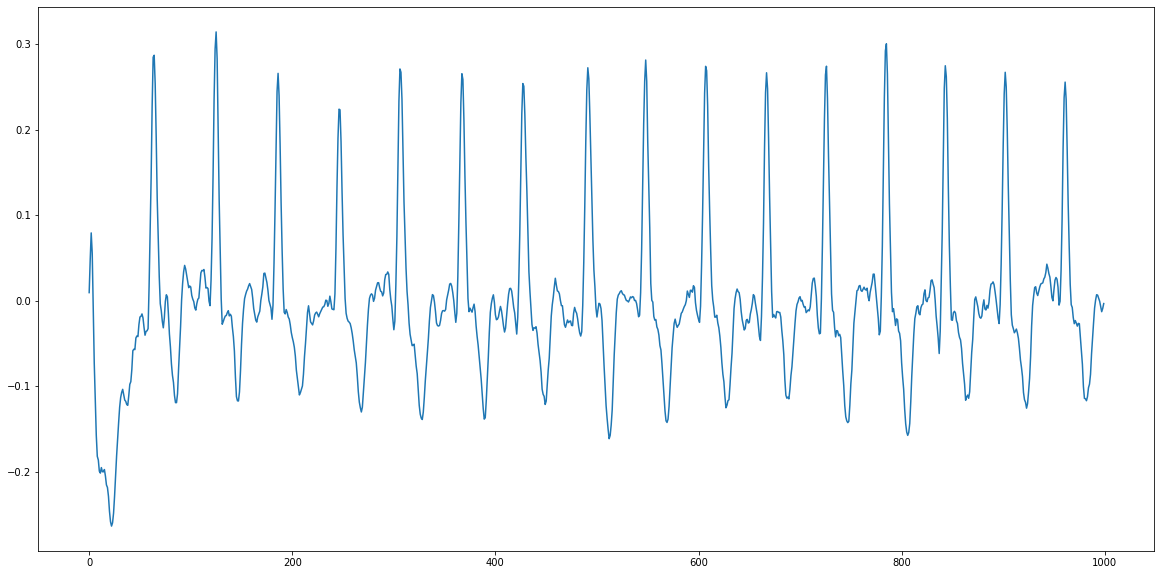

In [25]:
sample_rate = 100
filtered_data_1 = butter_highpass(0.5, sample_rate, 2, m_a_filtered)
plt.plot(filtered_data_1);

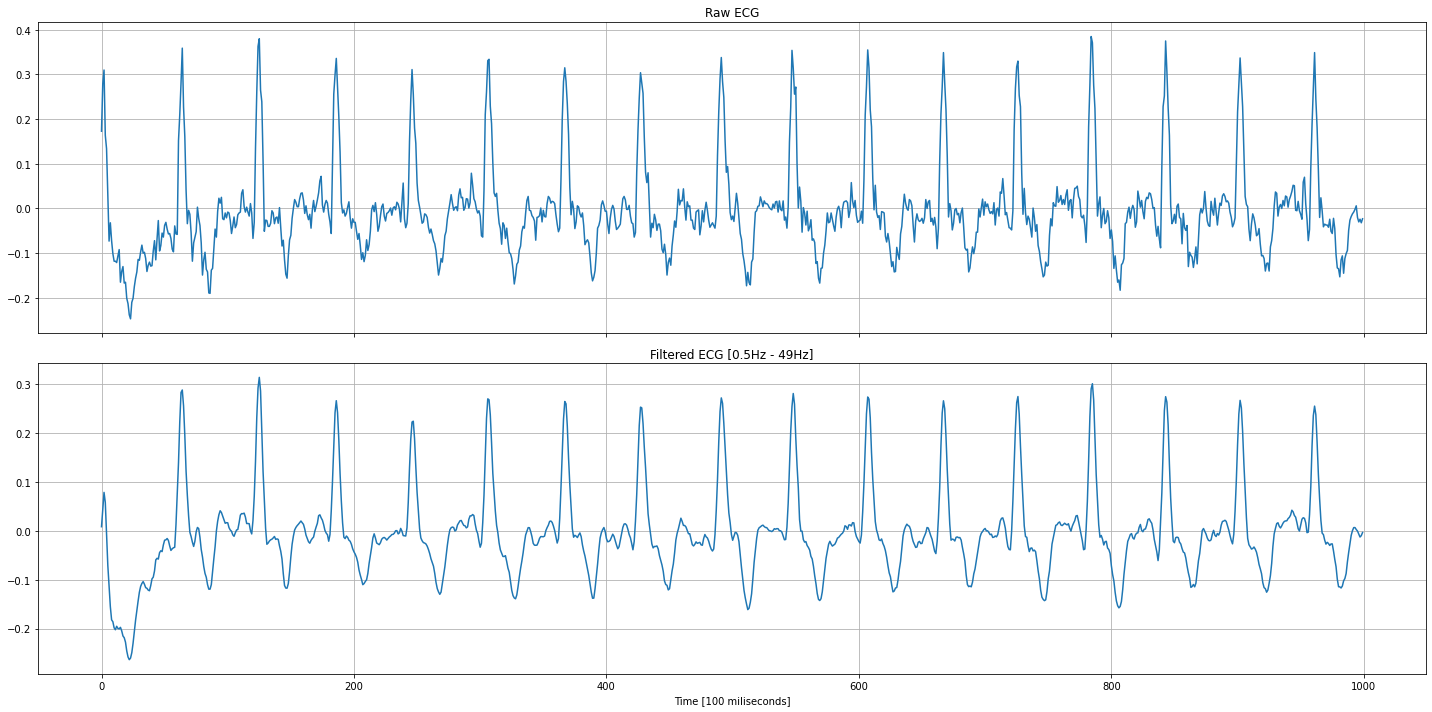

In [26]:
final_filtered_data = butter_lowpass(49, sample_rate, 5, filtered_data_1)
plot_signals_for_comparison(X[2080],final_filtered_data)

## Analysing with biosppy
- https://biosppy.readthedocs.io/en/stable/

In [87]:
import biosppy
from biosppy.signals import ecg

In [88]:
sr = X[2080] #SR example
afib = X[0] #AFIB example

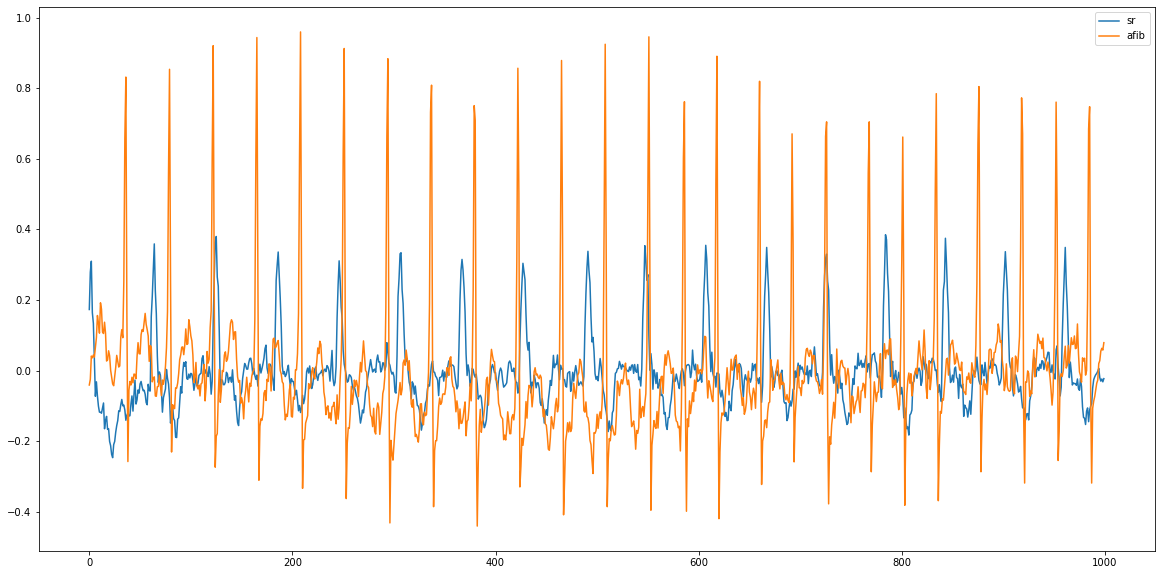

In [89]:
plt.plot(sr, label = 'sr');
plt.plot(afib, label = 'afib')
plt.legend();

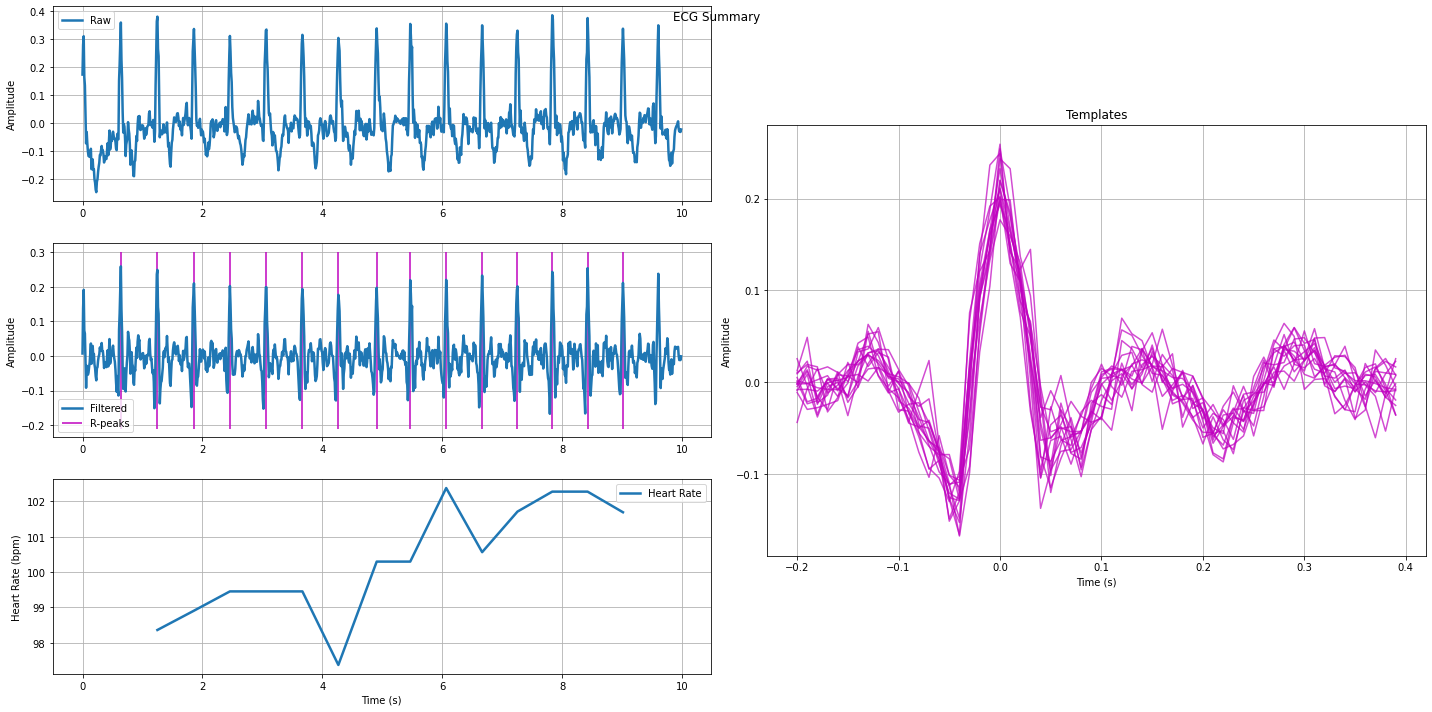

In [90]:
out = ecg.ecg(signal=sr, sampling_rate=100, show=True);

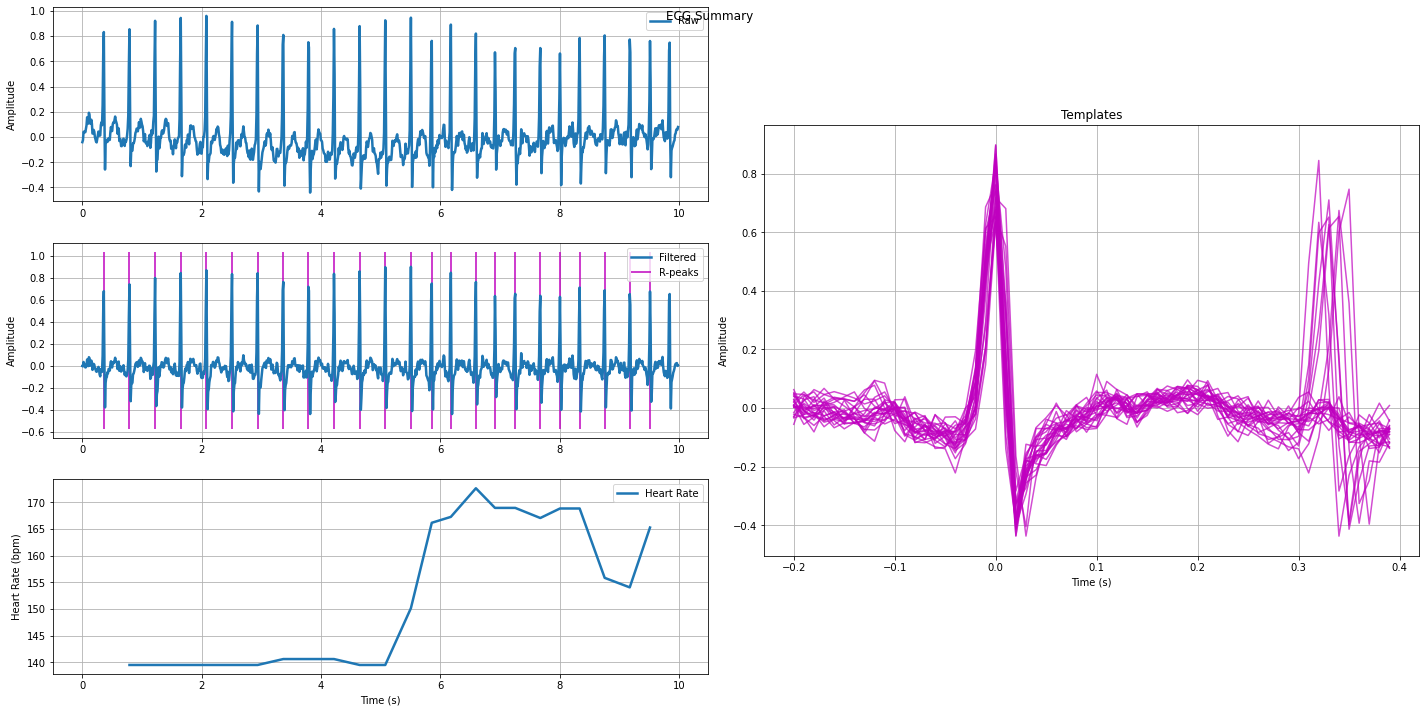

In [91]:
out = ecg.ecg(signal=afib, sampling_rate=100, show=True);

In [66]:
# Verify cases with AFIB (0 ==> 1513)

In [83]:
y[0]

1

In [84]:
y[1513]

1

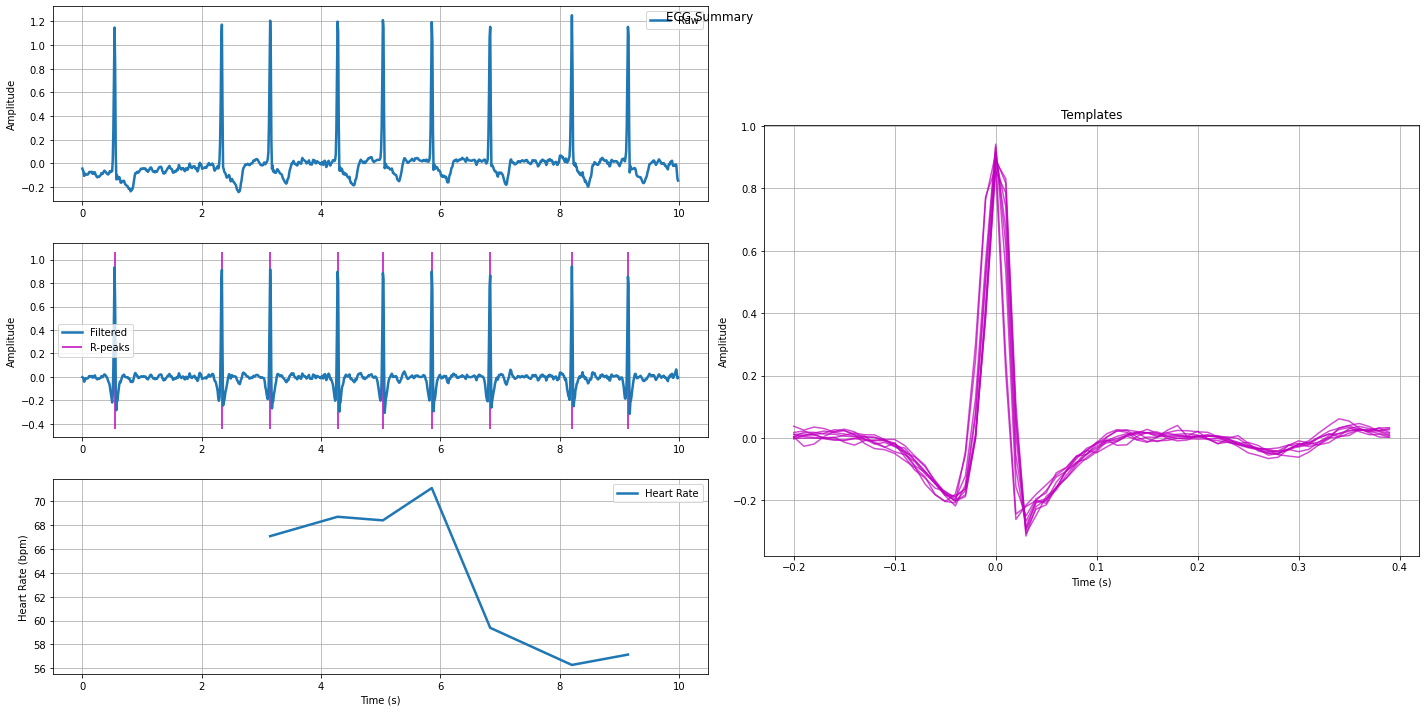

In [73]:
out = ecg.ecg(signal=X[3], sampling_rate=100, show=True);

In [ ]:
# Verify cases with SR (1514 ==> 3027)

In [79]:
y[1514]

0

In [82]:
y[3027]

0

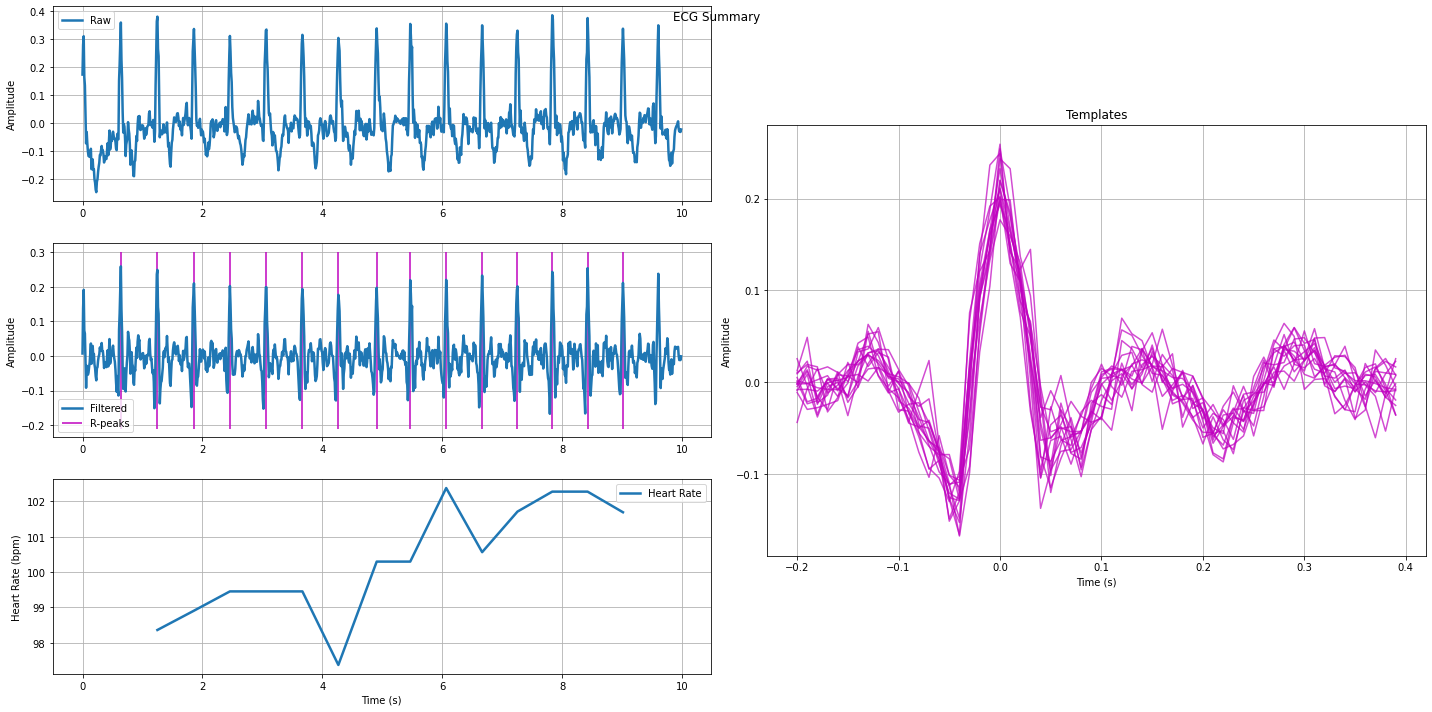

In [86]:
out = ecg.ecg(signal=X[2080], sampling_rate=100, show=True);

### Getting Heartbit Templates
- [ECG arrhythmia classification using a 2-D
convolutional neural network](https://medium.datadriveninvestor.com/ecg-arrhythmia-classification-using-a-2-d-convolutional-neural-network-33aa586bad67)

In [96]:
def get_Heartbit(data, sampling_rate=100):
    signals = []
    indices = []
    count = 1
    peaks = biosppy.signals.ecg.christov_segmenter(
        signal=data, sampling_rate=sampling_rate)[0]
    for i in (peaks[1:-1]):
        diff1 = abs(peaks[count - 1] - i)
        diff2 = abs(peaks[count + 1] - i)
        x = peaks[count - 1] + diff1 // 2
        y = peaks[count + 1] - diff2 // 2
        signal = data[x:y]
        signals.append(signal)
        count += 1
        indices.append((x, y))
    return signals, indices

In [115]:
signals, indices = get_Heartbit(X[2080])

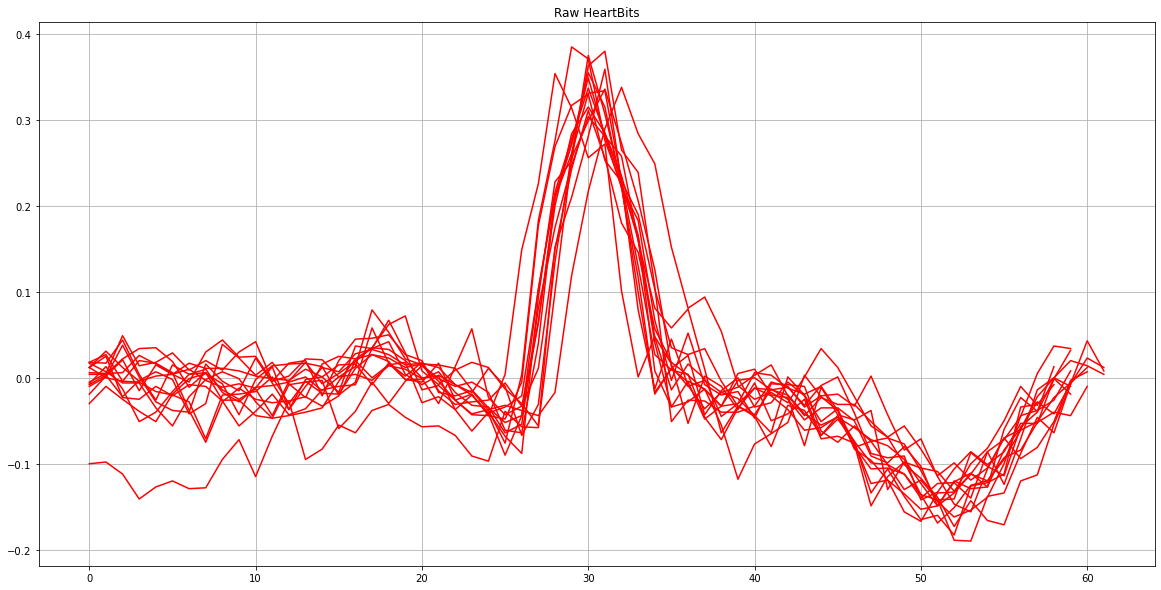

In [116]:
for i in range(len(signals)):
    plt.plot(signals[i], color = 'r')
    plt.title("Raw HeartBits")
    plt.grid()

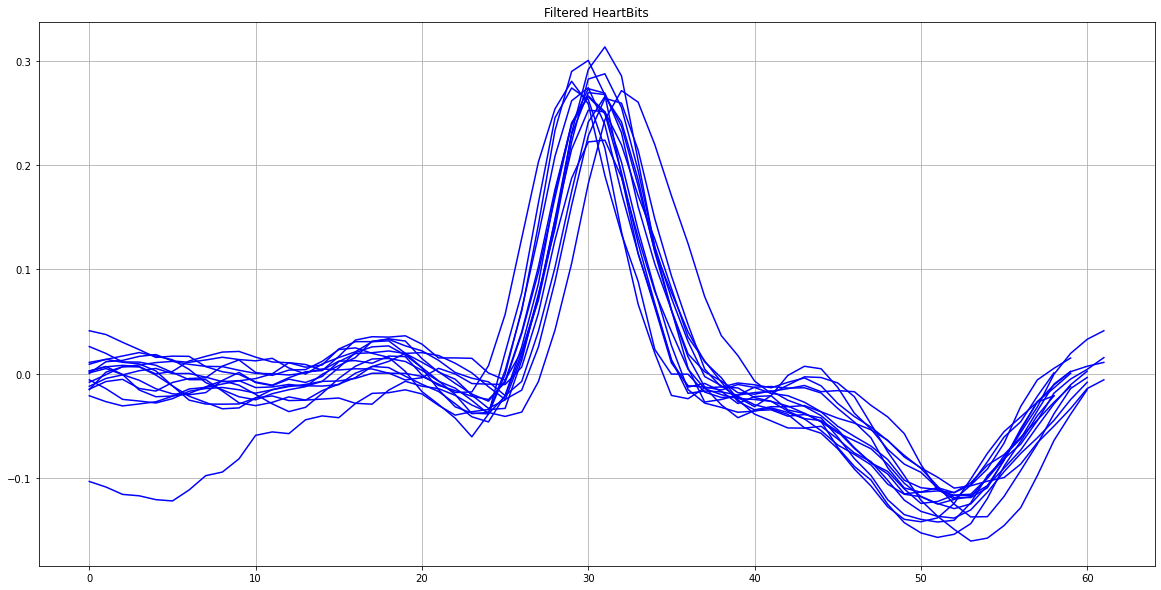

In [117]:
filtered_data = filter_data(X[2080])
signals, indices = get_Heartbit(filtered_data)
for i in range(len(signals)):
    plt.plot(signals[i], color = 'b')
    plt.title("Filtered HeartBits")
    plt.grid()